5.1560853e-11


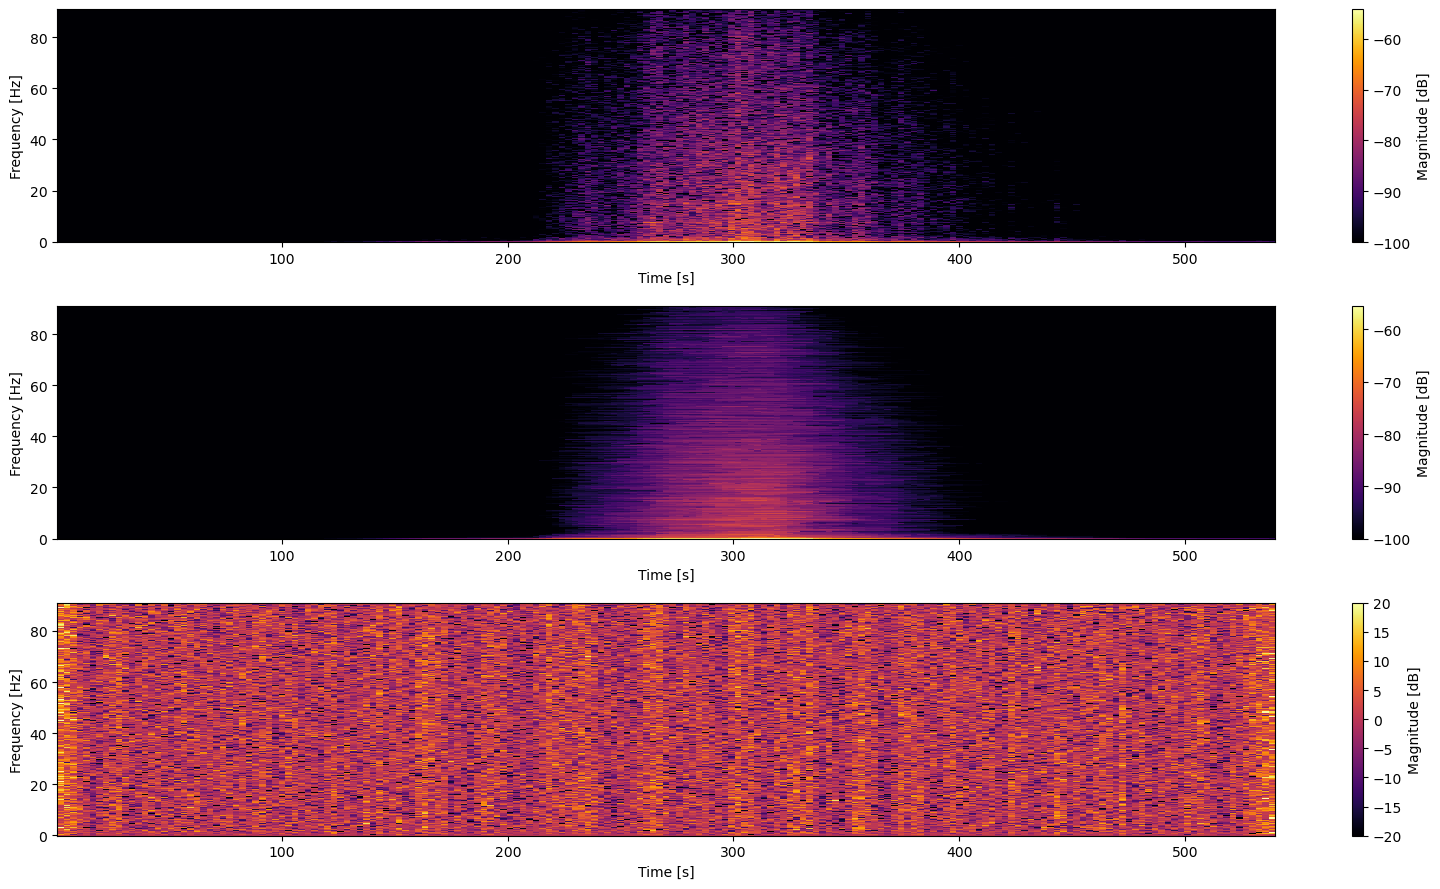

In [42]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftshift, fftfreq    # FFT and helper functions
import numpy as np



from scipy.signal import hilbert, resample_poly
import librosa

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"

#Getting data from wav file
data_org, sr = librosa.load(input_file)

#downsampling audio data
Fs = 2000 #[Hz]
data_offcet = resample_poly(data_org,1,int(sr/Fs))


#Removing Dc-offcet from data
dc_offcet = np.mean(data_offcet)
data = data_offcet - dc_offcet

t = np.linspace(0,(len(data_offcet)/Fs),len(data_offcet))

#Hilbert transform ov data
analytic_signal = np.absolute(hilbert(data))
#Squaring each element
h_2 = np.square(analytic_signal)

#Moving avg filter
med_filt_size = 11
h_filt = signal.medfilt(h_2,med_filt_size)

#Downsampling
DS_h = resample_poly(h_filt,1,med_filt_size)
DS_Fs = Fs/med_filt_size
DS_t = np.linspace(0,(len(DS_h)/DS_Fs),len(DS_h))


#Henter ut spectrogram for DEMON (demon_sx)
demon_f, demon_t, demon_sx = signal.spectrogram(DS_h, DS_Fs, nperseg=600, detrend=False)
print(demon_sx[0][1])
#med filt over hver kolonne
demon_sx_med = np.zeros((len(demon_sx),len(demon_sx[0])))
for k in range(len(demon_sx)):
    demon_sx_med[k] = signal.medfilt(demon_sx[k],kernel_size=11)

demon_sx_norm = demon_sx/demon_sx_med


# Plot spectrogram
plt.figure(figsize=(16, 9))  # Define figure for results
plt.subplot(3,1,1)
plt.pcolormesh(demon_t, demon_f, 10*np.log10(demon_sx), vmin=-100, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale

plt.subplot(3, 1, 2)
plt.pcolormesh(demon_t, demon_f, 10*np.log10(demon_sx_med), vmin=-100, cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale


plt.subplot(3,1,3)
plt.pcolormesh(demon_t, demon_f, 10*np.log10(demon_sx_norm), vmin=-20, vmax=20,cmap='inferno')  # Draw spectrogram image
plt.xlabel("Time [s]")         # Axis labels and scales
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale
plt.tight_layout()


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_76132/1744033013.py:10: RuntimeWarning: divide by zero encountered in log10
  signal_1 = 10*np.log10(signal.medfilt(DS_h,kernel_size=kernel_size)/noice) - trigger


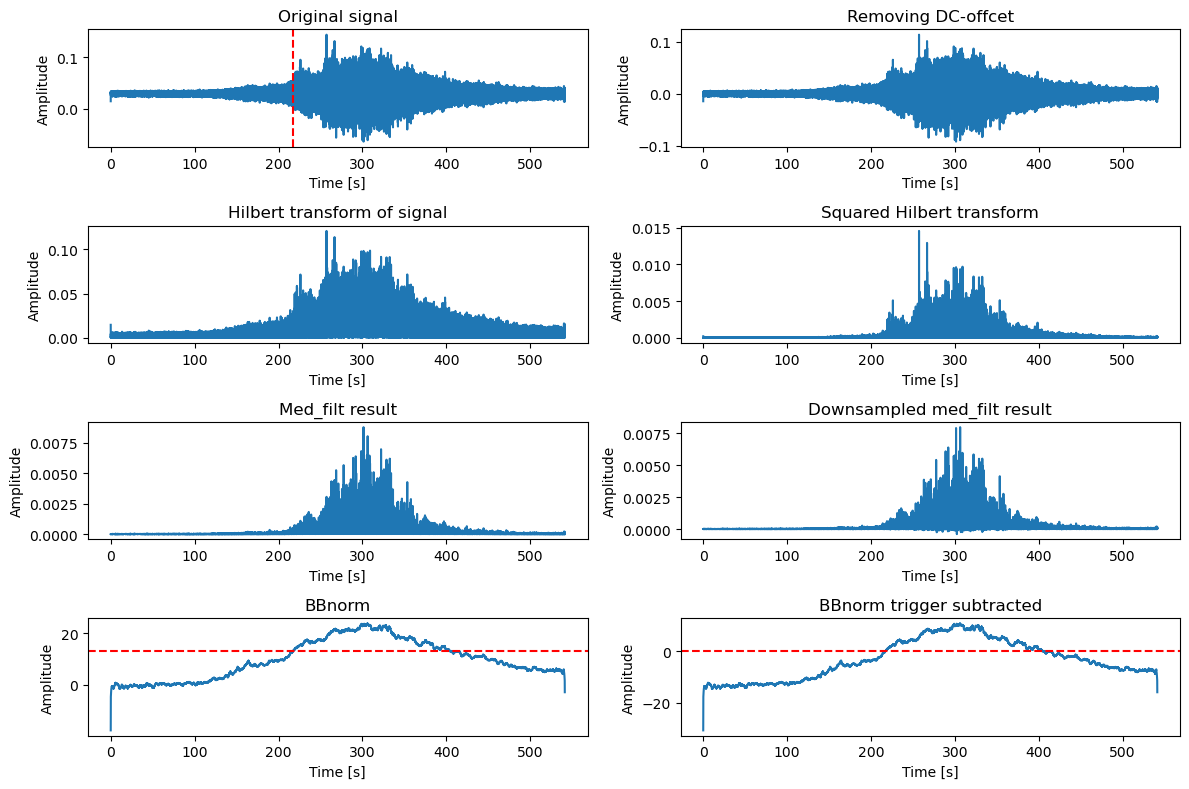

In [44]:
noice_t_start = 0
window_size = 2.5
trigger = 13
noice_t_stop = int((noice_t_start+window_size)*DS_Fs)
noice = np.mean(DS_h[noice_t_start:noice_t_stop])

#If even +1, if odd ok
kernel_size = int(window_size*DS_Fs)+int(int(window_size*DS_Fs) % 2 == 0)

signal_1 = 10*np.log10(signal.medfilt(DS_h,kernel_size=kernel_size)/noice) - trigger
try:
    indices = np.where(signal_1 > 0)[0]
    Trigger_time_1 = indices[0]/DS_Fs
except:
    Trigger_time_1 = 0
    print("trigger too high")

#plotting results
plt.figure(figsize=(12,8))

plt.subplot(4,2,1)
plt.plot(t,data_offcet)
plt.axvline(x=Trigger_time_1,color='red',linestyle='--')
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,2)
plt.plot(t,data)
plt.title("Removing DC-offcet")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,3)
plt.plot(t,analytic_signal)
plt.title("Hilbert transform of signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,4)
plt.plot(t,h_2)
plt.title("Squared Hilbert transform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,5)
plt.plot(t,h_filt)
plt.title("Med_filt result")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,6)
plt.plot(DS_t,DS_h)
plt.title("Downsampled med_filt result")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")



plt.subplot(4,2,7)
plt.plot(DS_t,signal_1 + trigger)
plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
plt.title("BBnorm")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(4,2,8)
plt.plot(DS_t,signal_1)
plt.axhline(y=0, color='red', linestyle='--', label="Trigger")
plt.title("BBnorm trigger subtracted")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [43]:
#Hilbert spectrogram
def plot_spectrogram(x, t, fs, n_segment, f_max, s_min):
    """Plot spectrogram of signal x.

    Parameters
    ----------
    x: array of floats
        Signal in time-domain
    t: Numpy array of floats
        Time vector for x
    fs: float
        Sample rate [Samples/s]
    n_segmend: int
        No. of samples in segment for spectrogram calculation
    f_max: float
        Max. on frequency axis
    """
    # Configure spectrogram
    #s_min = -50       # Minimum on the intensity plot. Lower values are 'black'
		
    # Calculate spectrogram
    f, t, sx = signal.spectrogram(x, fs, nperseg=n_segment, detrend=False)
    sx_db = 10*np.log10(sx/sx.max())   # Convert to dB
    		
    # Plot spectrogram
    plt.figure(figsize=(16, 6))  # Define figure for results	
    plt.subplot(1, 1, 1)
    
    plt.pcolormesh(t, f, sx_db, vmin=s_min, cmap='inferno')  # Draw spectrogram image
    print(f.max())		
    plt.xlabel("Time [s]")         # Axis labels and scales
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, f_max)
    		
    plt.colorbar(label="Magnitude [dB]")  # Colorbar for intensity scale
    plt.show()
    return 0

90.9090909090909


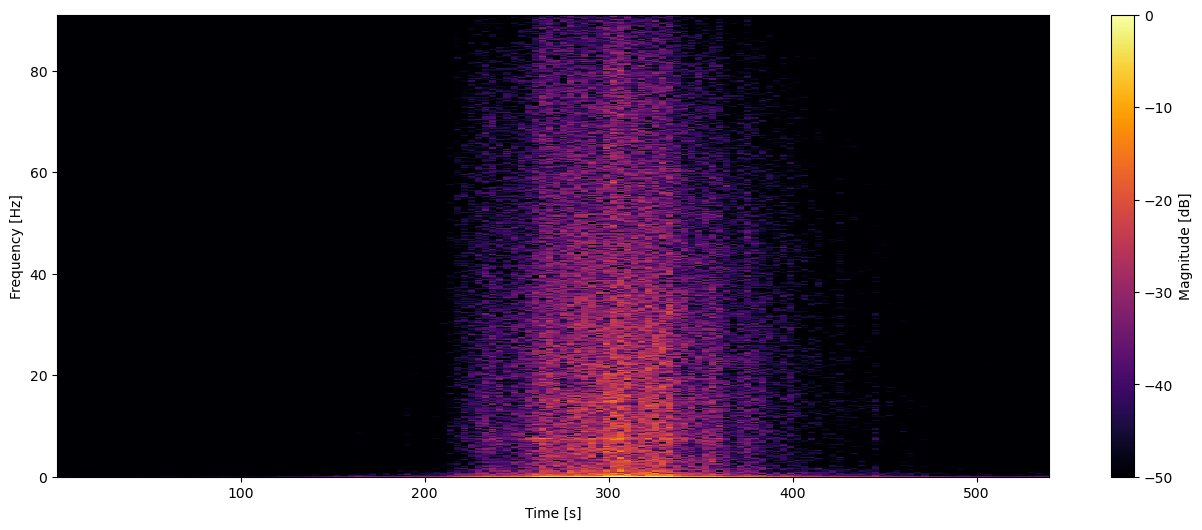

In [37]:
DS_spec = plot_spectrogram(DS_h,DS_t,DS_Fs,800,None,-50)

